In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train', 'test']


In [2]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up off currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks.(for representation purposes)

In [3]:
TRAIN_DIR = '../input/train'
TEST_DIR = '../input/test'

IMG_SIZE = 50            # we later resize the image to 50x50 for computation
LR=1e-3    #0.001 

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '2conv-basic') 
# just so we remember which saved model is which as we are going to change and tweek few things as we go through this,check for the sizes
# when we load a model into a neural net which differs in size then we get an error

In [4]:
# converting the labels to one-hot array
def label_img(img):
    # dog.89.png
    word_label=img.split('.')[-3]   # -3 is the dog;-2 is 89 and -1 is png
    if word_label=='cat':
        return [1,0]
    elif word_label=='dog':
        return [0,1]

tqdm provides a , way to measure where you are in a process, rather than printing things out at intervals...etc, it gives a progress bar.

In [5]:
def create_train_data():
    training_data=[]
    for img in tqdm(os.listdir(TRAIN_DIR)):  
        label= label_img(img)
        path=os.path.join(TRAIN_DIR,img)
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)           # o is for gray scale(cv2.IMREAD_GRAYSCALE)
        img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy',training_data)
    return training_data

When we've gone through all of the images, we shuffle them, then save. Shuffle modifies a variable in place, so there's no need to re-define it here.

With this function, we will both save, and return the array data. This way, if we just change the neural network's structure, and not something with the images, like image size..etc..then we can just load the array file and save some processing time. While we're here, we might as well also make a function to process the testing data. This is the actual competition test data, NOT the data that we'll use to check the accuracy of our algorithm as we test. This data has no label.

In [6]:
def process_test_data():
    testing_data=[]
    for img in tqdm(os.listdir(TEST_DIR)):
        path=os.path.join(TEST_DIR,img)

        #83.png
        img_num=img.split('.')[0]
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img),img_num])
    shuffle(testing_data)
    np.save('test_data.npy',testing_data)
    return testing_data

In [7]:
train_data=create_train_data()
# once we have trained we do not need to retrain it instead we can just use np.load('train_data.npy')

100%|██████████| 25000/25000 [00:45<00:00, 544.96it/s]


In [10]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

We wont be training our model from scratch every time.Maybe first you just want to see how 3 epochs trains, but then, after 3, maybe you're done, or maybe you want to see about 5 epochs. We want to be saving our model after every session, and reloading it if we have a saved version, so we add this:

In [11]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

In [12]:
train=train_data[:-500]
test=train_data[-500:]

array[:,0] and array[:,1] did NOT work for me here. Not sure what I'm doing wrong, so I do this instead to separate my features and labels:

In [13]:
X=np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y=[i[1] for i in train]

test_x=np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y=[i[1] for i in test]

In [12]:
model.fit({'input': X}, {'targets': Y}, n_epoch=2, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=50000, show_metric=True, run_id=MODEL_NAME)


Training Step: 765  | total loss: 11.60180 | time: 67.889s
| Adam | epoch: 002 | loss: 11.60180 - acc: 0.4961 -- iter: 24448/24500
Training Step: 766  | total loss: 11.66486 | time: 69.082s
| Adam | epoch: 002 | loss: 11.66486 - acc: 0.4934 | val_loss: 11.78924 - val_acc: 0.4880 -- iter: 24500/24500
--


well 49% doesniot give us anything

if you haven't made accuracy progress in the first 3 epochs, you're probably not going to at all, unless it's due to overfitment. So now we try to increase the size of the model

In [14]:
import tensorflow as tf
tf.reset_default_graph()   #we need to reset the graph instance, since we're doing this in a continuous environment

In [15]:
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')



if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=4, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)


Training Step: 1531  | total loss: 0.36797 | time: 64.574s
| Adam | epoch: 004 | loss: 0.36797 - acc: 0.8404 -- iter: 24448/24500
Training Step: 1532  | total loss: 0.36556 | time: 65.687s
| Adam | epoch: 004 | loss: 0.36556 - acc: 0.8439 | val_loss: 0.48923 - val_acc: 0.7720 -- iter: 24500/24500
--


Here the accuracy has improved after increasing the size of the network but it may not always be so as incresing size after a limit tends to overfit the data.We could have use dropouts to minimise this.

In [17]:
model.save(MODEL_NAME)     # we save the model of 84.39%

In [16]:
# if you need to create the data:
test_data = process_test_data()
# if you already have some saved:
#test_data = np.load('test_data.npy')

100%|██████████| 12500/12500 [00:37<00:00, 332.33it/s]


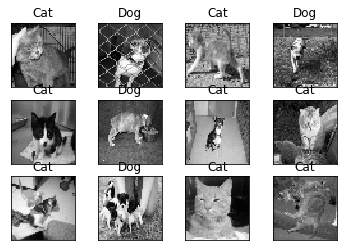

In [18]:
import matplotlib.pyplot as plt

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [19]:
# To make a submission to kaggle
'''
with open('submission_file.csv','w') as f:
    f.write('id,label\n')
            
with open('submission_file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))'''

"\nwith open('submission_file.csv','w') as f:\n    f.write('id,label\n')\n            \nwith open('submission_file.csv','a') as f:\n    for data in tqdm(test_data):\n        img_num = data[1]\n        img_data = data[0]\n        orig = img_data\n        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)\n        model_out = model.predict([data])[0]\n        f.write('{},{}\n'.format(img_num,model_out[1]))"